<a href="https://colab.research.google.com/github/HackerJacky/Crypto-quantitative-analysis/blob/main/crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install pyfolio-reloaded

In [ ]:
pip install alphalens-reloaded

In [ ]:
pip install "git+https://github.com/tidy-finance/py-fmpapi"

  Cloning https://github.com/tidy-finance/py-fmpapi to /tmp/pip-req-build-ripfon_j
  Running command git clone --filter=blob:none --quiet https://github.com/tidy-finance/py-fmpapi /tmp/pip-req-build-ripfon_j
  Resolved https://github.com/tidy-finance/py-fmpapi to commit d17cb77e368ae8270e9abf32c8640e6ba67505d6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from fredapi import Fred
warnings.filterwarnings('ignore')

In [ ]:
start='2020-01-01'
end='2025-11-20'
#Bitcoin closed price
BTC = yf.download('BTC-USD', start=start, end=end)['Close'].dropna()
#Micorstrategy closed price
Micro = yf.download('MSTR', start=start, end=end)['Close'].dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#做定態檢定


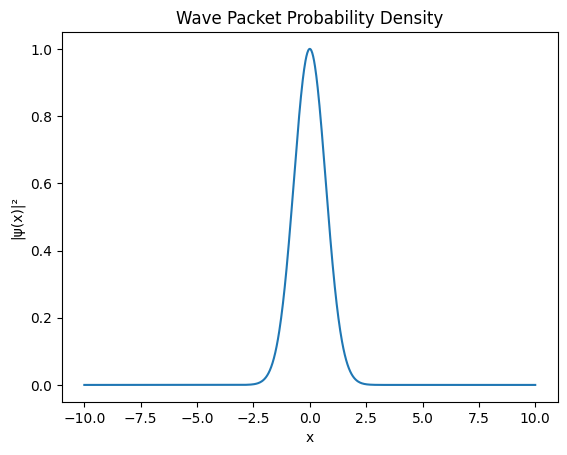

正在下載 MSTR, BTC-USD 從 2020-01-01 到 2025-11-12 的數據...


/tmp/ipython-input-4008865535.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9

數據下載並清理完成。
Ticker              BTC    MSTR
Date                           
2020-01-01  7200.174316  14.431
2020-01-02  6985.470215  14.357
2020-01-05  7411.317383  14.425
2020-01-06  7769.219238  14.387
2020-01-07  8163.692383  14.371

每日回報率 (前5筆):
Ticker           BTC      MSTR
Date                          
2020-01-02 -0.029819 -0.005128
2020-01-05  0.060962  0.004736
2020-01-06  0.048291 -0.002634
2020-01-07  0.050774 -0.001112
2020-01-08 -0.010269 -0.001461

--- 價格相關性矩陣 ---
Ticker      BTC     MSTR
Ticker                  
BTC     1.00000  0.93529
MSTR    0.93529  1.00000
MSTR 與 BTC 的「價格」相關性: 0.9353

--- 每日回報率相關性矩陣 ---
Ticker      BTC     MSTR
Ticker                  
BTC     1.00000  0.13173
MSTR    0.13173  1.00000
MSTR 與 BTC 的「每日回報率」相關性: 0.1317

正在生成可視化圖表...


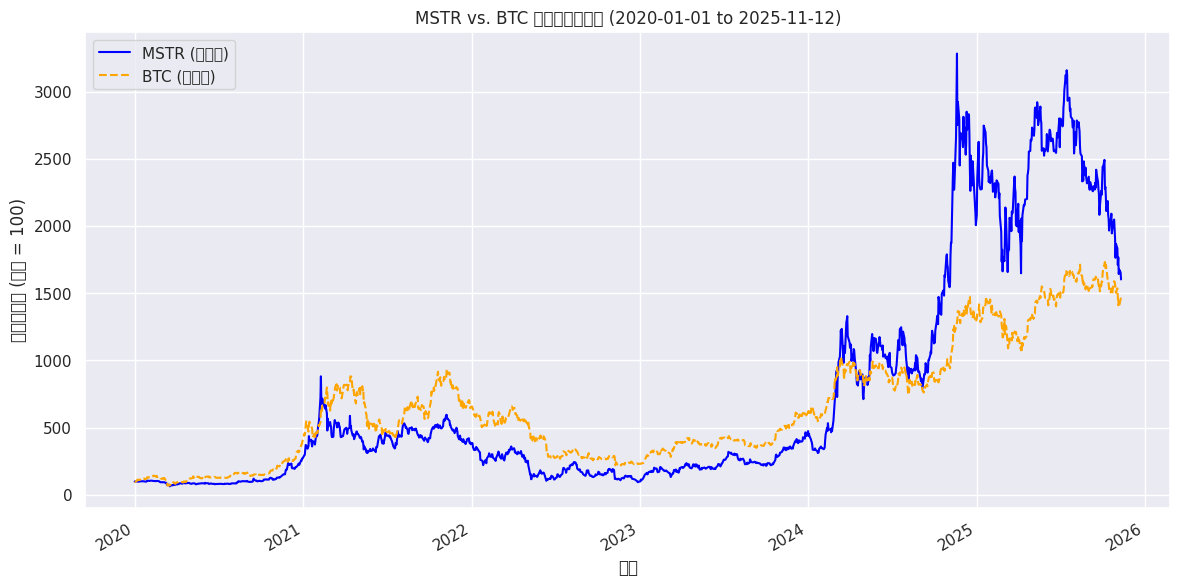

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22577 (\N{CJK UNIFIED IDEOGRAPH-5831}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  fig.canvas

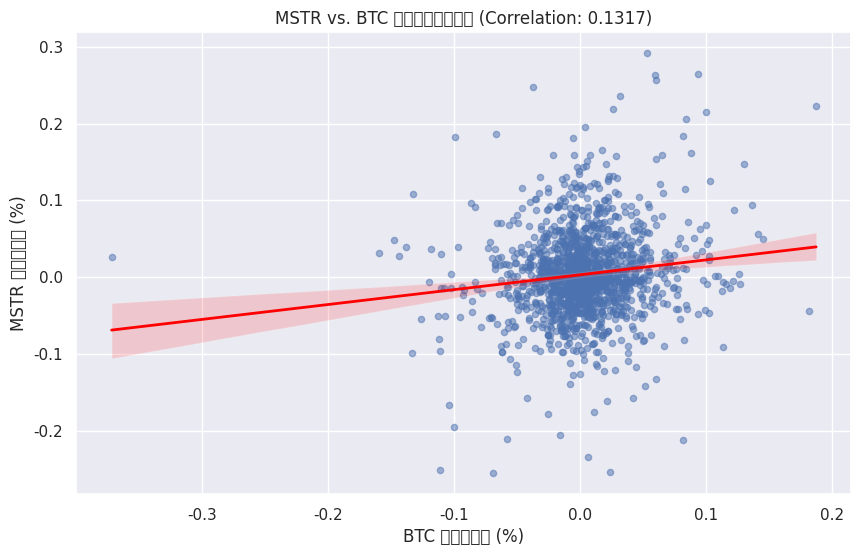

分析完成。


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 設定參數 ---
tickers = ['MSTR', 'BTC-USD']
start_date = '2020-01-01'  # MSTR 在 2020 年中開始大量購買 BTC，從這年開始看很合適
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

print(f"正在下載 {', '.join(tickers)} 從 {start_date} 到 {end_date} 的數據...")

# --- 2. 下載數據 ---
# 我們只需要 'Adj Close' (調整後收盤價)
try:
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    data['MSTR']=data['MSTR'].shift(-1)
    data = data.rename(columns={'BTC-USD': 'BTC'}) # 欄位改名方便操作
except Exception as e:
    print(f"數據下載失敗: {e}")
    exit()

# --- 3. 數據清理 ---
# 加密貨幣 24/7 交易，股票則否。yfinance 會自動對齊
# 我們移除任一資產沒有交易數據的日期 (例如 MSTR 的週末或假B期)
original_price = data.dropna()

if original_price.empty:
    print("數據為空，請檢查 Tickers 或日期範圍。")
    exit()

print("數據下載並清理完成。")
print(original_price.head())

# --- 4. 計算每日回報率 (Percent Change) ---
# 警告：直接分析價格相關性 (Price Correlation) 常常有誤導性 (偽相關)
# 分析「每日回報率」的相關性才是金融上更標準、更穩健的做法。
daily_returns = original_price.pct_change().dropna()

print("\n每日回報率 (前5筆):")
print(daily_returns.head())

# --- 5. 計算相關性 ---

# 5a. 價格相關性 (通常很高，但參考價值較低)
price_corr = original_price.corr()
print("\n--- 價格相關性矩陣 ---")
print(price_corr)
print(f"MSTR 與 BTC 的「價格」相關性: {price_corr.loc['MSTR', 'BTC']:.4f}")

# 5b. 每日回報率相關性 (這才是重點！)
returns_corr = daily_returns.corr()
print("\n--- 每日回報率相關性矩陣 ---")
print(returns_corr)
print(f"MSTR 與 BTC 的「每日回報率」相關性: {returns_corr.loc['MSTR', 'BTC']:.4f}")


# --- 6. 數據可視化 ---

# 設定圖表樣式
sns.set(style='darkgrid')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Heiti TC'] # 支援中文標題
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# 圖 1: 標準化價格走勢圖
# (價格 / 其實點價格) * 100，觀察兩者走勢
print("\n正在生成可視化圖表...")
normalized_price = (original_price / original_price.iloc[0] * 100)

plt.figure(figsize=(14, 7))
normalized_price['MSTR'].plot(label='MSTR (標準化)', color='blue')
normalized_price['BTC'].plot(label='BTC (標準化)', color='orange', linestyle='--')
plt.title(f'MSTR vs. BTC 標準化價格走勢 ({start_date} to {end_date})')
plt.ylabel('標準化價格 (基期 = 100)')
plt.xlabel('日期')
plt.legend()
plt.show()


# 圖 2: 每日回報率相關性散點圖 (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.regplot(data=daily_returns, x='BTC', y='MSTR',
            line_kws={"color": "red", "linewidth": 2},  # 迴歸線
            scatter_kws={"alpha": 0.5, "s": 20})       # 散點
plt.title(f'MSTR vs. BTC 每日回報率相關性 (Correlation: {returns_corr.loc["MSTR", "BTC"]:.4f})')
plt.xlabel('BTC 每日回報率 (%)')
plt.ylabel('MSTR 每日回報率 (%)')
plt.show()

print("分析完成。")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mrst=yf.download('MSTR',start='2020-01-01',end='2025-11-12')['Close'].dropna().shift(-1)
btc=yf.download('BTC-USD',start='2020-01-01',end='2025-11-12')['Close'].dropna()
corr=mrst.corr(btc)
print(corr)


/tmp/ipython-input-3578233571.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  mrst=yf.download('MSTR',start='2020-01-01',end='2025-11-12')['Close'].dropna().shift(-1)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3578233571.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc=yf.download('BTC-USD',start='2020-01-01',end='2025-11-12')['Close'].dropna()
[*********************100%***********************]  1 of 1 completed


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().